# Grad-CAM Explainability Notebook

## Imports and Setup

In [28]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

## Define Custom CNN Architecture

In [29]:
def build_custom_cnn():
  model = Sequential([
      # 1st Convolutional Layer
      Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
      MaxPooling2D(2,2), # Downsample feature maps by 2x2

      # 2nd Convolutional Layer
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),

      # Flatten to 1D vector for Dense layers
      Flatten(),

      # Fully connected layer
      Dense(128, activation='relu'),
      Dropout(0.5),     # Dropout to prevent overfitting

      # Output layer for binary classification
      Dense(1, activation='sigmoid')
  ])
  return model

custom_cnn_model = build_custom_cnn()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Load & Initialize Model

In [30]:
custom_cnn_model.load_weights("/content/models/custom_cnn.keras")

## Build the Grad-CAM Function

In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
  intermediate_outputs = []

  # Build a model that wraps the original model and extracts intermediate output
  input_tensor = tf.keras.Input(shape=(128, 128, 3))
  x = input_tensor
  conv_output = None

  # Replay each layer in the model on the new input tensor
  for layer in model.layers:
    x = layer(x)
    if layer.name == last_conv_layer_name:
      conv_output = x

  # Now x is the final output
  final_output = x

  # If we failed to find the conv layer
  if conv_output is None:
    raise ValueError(f"Layer {last_conv_layer_name} not found in model layers.")

  # Build a functional wrapper
  replay_model = tf.keras.Model(inputs=input_tensor,
                                outputs=[conv_output, final_output])

  with tf.GradientTape() as tape:
    conv_outputs, predictions = replay_model(img_array)
    loss = predictions[:, 0] # sigmoid binary

  # Compute gradients w.r.t. conv outputs
  grads = tape.gradient(loss, conv_outputs)

  # Global average pool gradients
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Weight the feature maps
  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # Normalize between 0 and 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  return heatmap.numpy()

## Prepare Images

In [21]:
def preprocess_image(img_path, img_size=(128, 128)):
  img = load_img(img_path, target_size=img_size)
  img_array = img_to_array(img)
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  return img_array

## Overlay Heatmap on Original Image

In [22]:
def display_gradcam(img_path, heatmap, alpha=0.4):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * alpha + img

  plt.figure(figsize=(5,5))
  plt.imshow(superimposed_img.astype("uint8"))
  plt.axis("off")
  plt.show()

## Run Grad-CAM

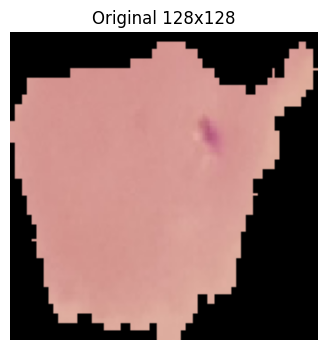

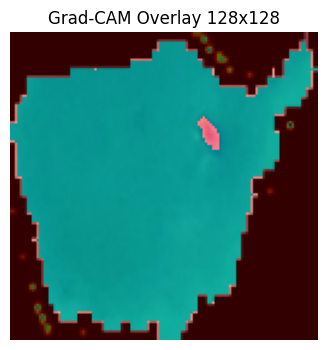

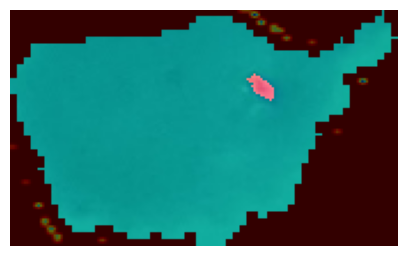

In [39]:
img_path = "/content/sample_images/C100P61ThinF_IMG_20150918_150041_cell_76.png"
img_array = preprocess_image(img_path)

# Create heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    custom_cnn_model,
    last_conv_layer_name="conv2d_1"
)

# Resize overlay to 128x128
heatmap_resized = cv2.resize(heatmap, (128, 128))
img_128 = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (128, 128))
heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
overlay_128 = heatmap_color * 0.4 + img_128


# Show Original Image
orig_img = load_img(img_path, target_size=(128,128))
plt.figure(figsize=(4,4))
plt.imshow(orig_img)
plt.axis('off')
plt.title("Original 128x128")
plt.show()

# Show model-input overlay (128x128)
plt.figure(figsize=(4,4))
plt.imshow(overlay_128.astype("uint8"))
plt.axis('off')
plt.title("Grad-CAM Overlay 128x128")
plt.show()

# Show full-resolution Grad-CAM Overlay
display_gradcam(img_path, heatmap)